In [1]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import sklearn as sk
from PIL import Image, ImageOps, ImageDraw
from tensorflow.keras.models import Model
from scipy.ndimage import rotate
import cv2
from mpl_toolkits.mplot3d import Axes3D

2024-05-29 18:09:11.539664: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 18:09:12.021454: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 18:09:12.997041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the binary file
data_train = np.load('games_train.npz', allow_pickle=True)
X_train = data_train['images']
X_train.astype('float32')
y_train = data_train['labels']
label_names = data_train['label_names']

print(label_names)

['CSGO' 'Fortnite' 'Forza Horizon' 'Genshin impact' 'Minecraft' 'Terraria'
 'Valorant']


In [3]:
data_test = np.load('games_test.npz', allow_pickle=True)
X_test = data_test['images']
X_test.astype('float32')
y_test = data_test['labels']
label_names = data_test['label_names']

print(label_names)

['CSGO' 'Fortnite' 'Forza Horizon' 'Genshin impact' 'Minecraft' 'Terraria'
 'Valorant']


In [4]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Type of X_train: {X_train.dtype}")

Shape of X_train: (21000, 56, 96, 3)
Type of X_train: float64


In [5]:
X_train[10000]

array([[[0.69803922, 0.78823529, 0.8745098 ],
        [0.27058824, 0.36078431, 0.4627451 ],
        [0.34117647, 0.43921569, 0.57254902],
        ...,
        [0.54901961, 0.41960784, 0.22352941],
        [0.77254902, 0.58039216, 0.24313725],
        [0.82745098, 0.61176471, 0.20392157]],

       [[0.45098039, 0.52941176, 0.62745098],
        [0.40784314, 0.49411765, 0.60392157],
        [0.41568627, 0.50980392, 0.65098039],
        ...,
        [0.39215686, 0.2627451 , 0.08627451],
        [0.77254902, 0.6       , 0.29803922],
        [0.78823529, 0.58823529, 0.22745098]],

       [[0.04313725, 0.10588235, 0.21960784],
        [0.44705882, 0.52156863, 0.65098039],
        [0.38431373, 0.48627451, 0.63137255],
        ...,
        [0.38431373, 0.27058824, 0.14901961],
        [0.7372549 , 0.58431373, 0.36862745],
        [0.8       , 0.63529412, 0.36470588]],

       ...,

       [[0.81176471, 0.83137255, 0.82352941],
        [0.80784314, 0.82745098, 0.81960784],
        [0.81568627, 0

In [6]:
def rotate_all_images(images, angle):
    images_255 = images * 255
    rotated_images = np.array([rotate(image, angle) for image in images_255])
    return rotated_images

In [7]:
def convert_to_grayscale(image_array):
    image_array = image_array * 255.0
    image_array = image_array.astype('uint8')
    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
        return cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    return image_array

In [8]:
X_train_gray = np.array([convert_to_grayscale(image) for image in X_train[:5]])
X_train_gray

array([[[140, 142, 137, ...,  98, 114, 102],
        [141, 139, 134, ...,  95, 102,  87],
        [134, 141, 137, ...,  96, 111, 107],
        ...,
        [ 51,  43, 126, ...,  44,  44,  45],
        [ 57,  47,  59, ...,  36,  39,  32],
        [ 44,  44,  37, ...,  33,  31,  35]],

       [[112, 112, 111, ...,  87,  81,  65],
        [116, 113, 111, ...,  63,  63,  60],
        [116, 116, 111, ...,  59,  54,  37],
        ...,
        [ 45,  31, 113, ...,  60,  62,  60],
        [ 28,  26,  31, ...,  55,  55,  54],
        [ 22,  23,  35, ...,  50,  45,  50]],

       [[133, 136, 128, ..., 138, 113, 140],
        [137, 133, 124, ..., 169, 121, 133],
        [136, 128, 135, ..., 169, 122, 127],
        ...,
        [ 35,  39,  37, ...,  51,  55,  58],
        [ 36,  32,  32, ...,  28,  45,  45],
        [ 28,  35,  27, ...,  20,  35,  40]],

       [[151, 146, 154, ..., 160, 168, 205],
        [139, 153, 145, ..., 208, 206, 215],
        [149, 142, 154, ..., 210, 208, 199],
        ..

In [9]:
def plot_images(original_images, rotated_images, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])  # Convert to uint8 for display
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(rotated_images[i].astype(np.uint8))
        plt.title("Rotated")
        plt.axis('off')
    plt.show()

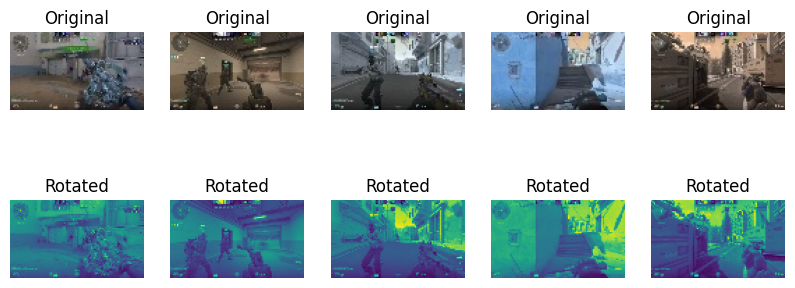

In [10]:
plot_images(X_train, X_train_gray)

In [11]:
def crop(X):
    X[:, :10, :, :] = 0  # First 5 rows
    X[:, -10:, :, :] = 0  # Last 5 rows

    X[:, :, :10, :] = 0  # First 5 columns
    X[:, :, -10:, :] = 0  # Last 5 columns

In [12]:
crop(X_test)
crop(X_train)

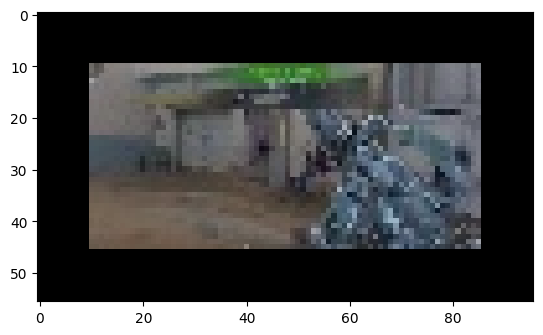

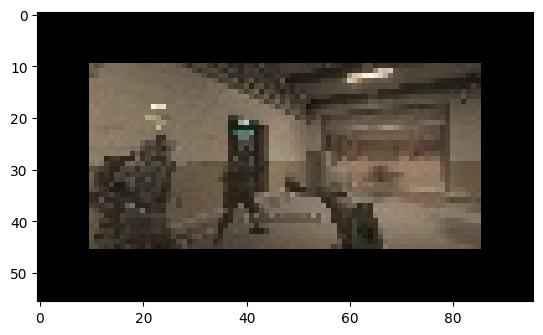

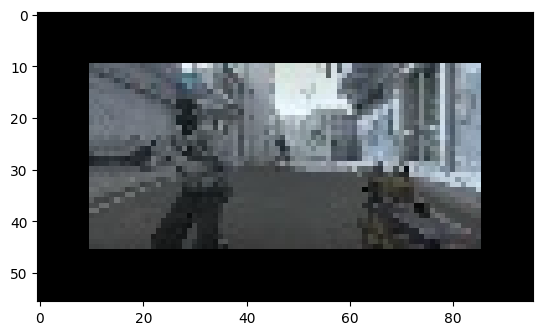

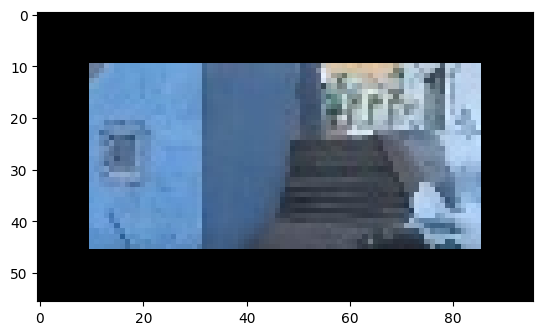

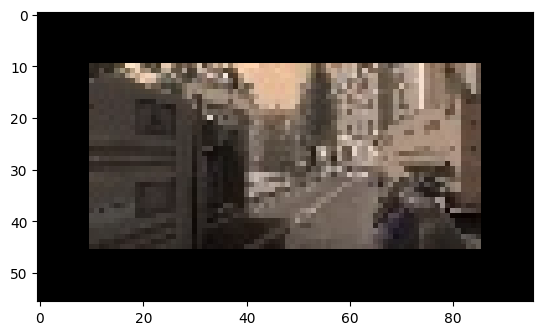

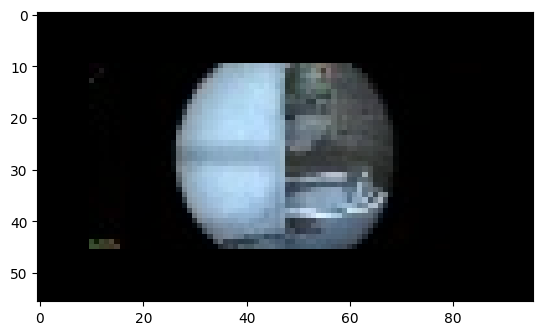

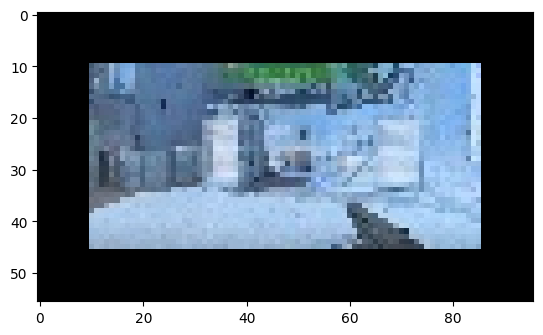

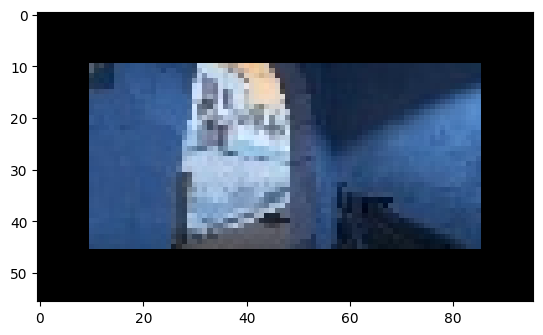

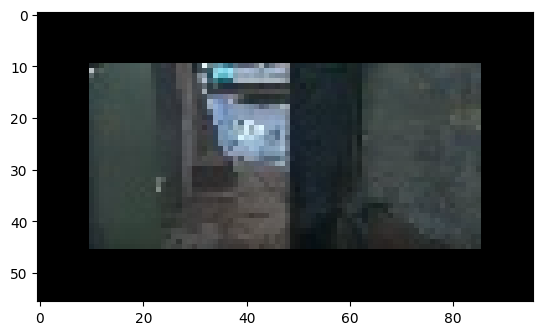

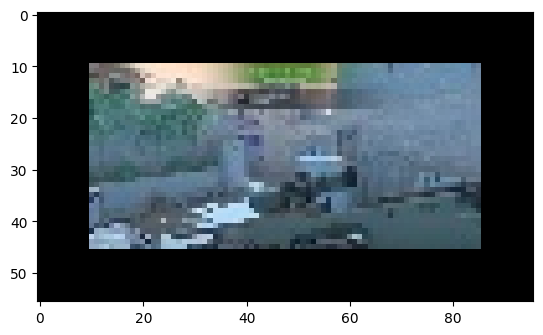

In [13]:
for i in range(10):
    plt.imshow(X_train[i])
    plt.show()

In [14]:
y_test = tf.keras.utils.to_categorical(y_test)
y_train = tf.keras.utils.to_categorical(y_train)

In [15]:
def nn_model(input_shape: tuple, num_classes: int):
    model = tf.keras.Sequential([
        Dense(32, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [16]:
def Cnn_model(input_shape: tuple, num_classes: int):
    model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
def train_model(model, x: np.array, y: np.array,
                x_test: np.array, y_test: np.array,
                batch_size: int = 32, epochs: int = 10):
    """
    Trains the model on the given data.

    :param keras.sequential model: the instanciated model to train
    :param numpy.array x: the training data
    :param numpy.array y: the true values
    :param numpy.array x_test: the test data
    :param numpy.array y_test: the true test values
    :param int batch_size: size of each processed batch
    :param int epochs: number of epochs
    """
    callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
    model.fit(x, y, epochs=10, batch_size=64, callbacks=[callback], validation_data=(x_test, y_test))

In [18]:
model_0 = nn_model(X_train.shape[1:], 7)

2024-05-29 18:09:25.844661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 18:09:25.844913: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
history = model_0.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4276 - loss: 1.5337 - val_accuracy: 0.5571 - val_loss: 1.2179
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.6794 - loss: 0.9371 - val_accuracy: 0.6593 - val_loss: 1.0395
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.7706 - loss: 0.7008 - val_accuracy: 0.6990 - val_loss: 0.9392
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.8138 - loss: 0.5723 - val_accuracy: 0.7557 - val_loss: 0.7927
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.8438 - loss: 0.4836 - val_accuracy: 0.7470 - val_loss: 0.8196
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.8659 - loss: 0.4222 - val_accuracy: 0.6944 - val_loss: 1.0446
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8797 - loss: 0.3720 - val_accuracy: 0.7259 - val_loss: 0.8465
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.8903 - loss: 0.3402 - 

In [20]:
model = Cnn_model(X_train.shape[1:], 7)

/home/lehuang/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.7282 - loss: 0.8473 - val_accuracy: 0.7904 - val_loss: 0.6904
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 37s 56ms/step - accuracy: 0.9318 - loss: 0.2097 - val_accuracy: 0.8309 - val_loss: 0.6533
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.9559 - loss: 0.1366 - val_accuracy: 0.8847 - val_loss: 0.3846
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.9712 - loss: 0.0874 - val_accuracy: 0.8650 - val_loss: 0.5243
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.9777 - loss: 0.0662 - val_accuracy: 0.8646 - val_loss: 0.5597
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.9819 - loss: 0.0583 - val_accuracy: 0.8947 - val_loss: 0.4265
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.9876 - loss: 0.0405 - val_accuracy: 0.8919 - val_loss: 0.3914
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.9878 - loss: 0.0376 - 

In [22]:
model.layers[0].output

<KerasTensor shape=(None, 54, 94, 32), dtype=float32, sparse=False, name=keras_tensor_7>

In [23]:
model.layers[0].input

<KerasTensor shape=(None, 56, 96, 3), dtype=float32, sparse=None, name=keras_tensor_6>

In [24]:
filters, biases = model.layers[0].get_weights()
biases

array([-0.02973196, -0.04184132, -0.00730434,  0.03006229,  0.02047511,
        0.00564428,  0.05074673,  0.06795605, -0.04711686,  0.03099846,
        0.07433963,  0.02502465,  0.06094153,  0.04174211, -0.06406359,
        0.14441164,  0.02195238,  0.0442089 , -0.0347806 , -0.01343711,
       -0.01833393,  0.0685968 , -0.02271111, -0.04930995, -0.00228563,
        0.04869012,  0.01476473,  0.02123243, -0.06449831, -0.11180838,
        0.07733039,  0.05772091], dtype=float32)

In [25]:
intermediate_layer_model = Model(inputs=model.layers[0].input, outputs=model.get_layer('dense_3').output)

intermediate_output = intermediate_layer_model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [26]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(intermediate_output)

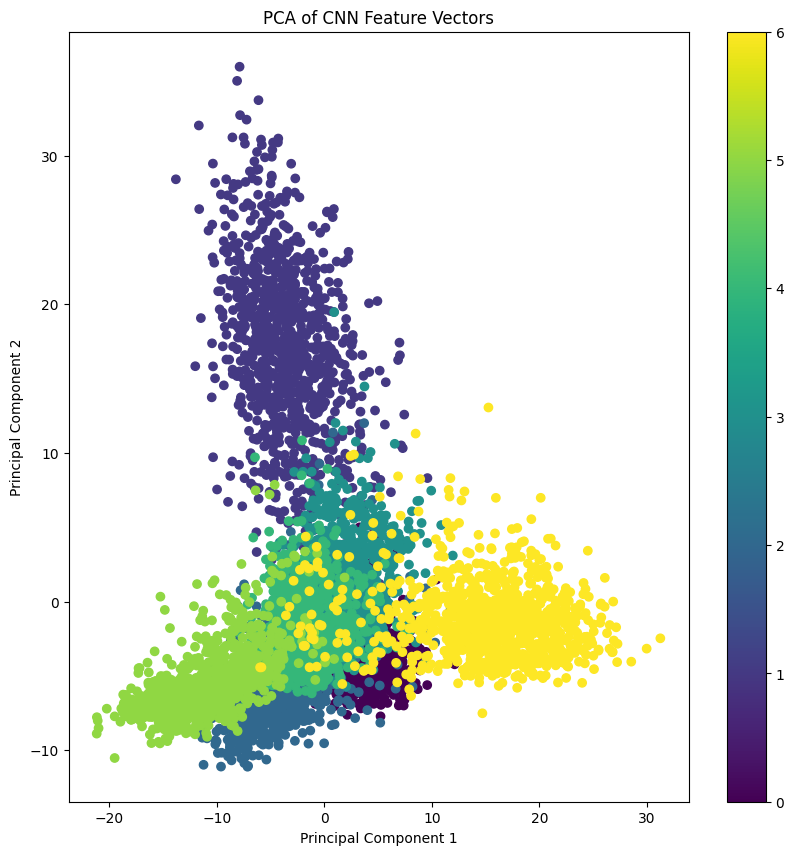

In [27]:
true_labels = np.argmax(y_test, axis=1)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=true_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('PCA of CNN Feature Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [28]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(intermediate_output)

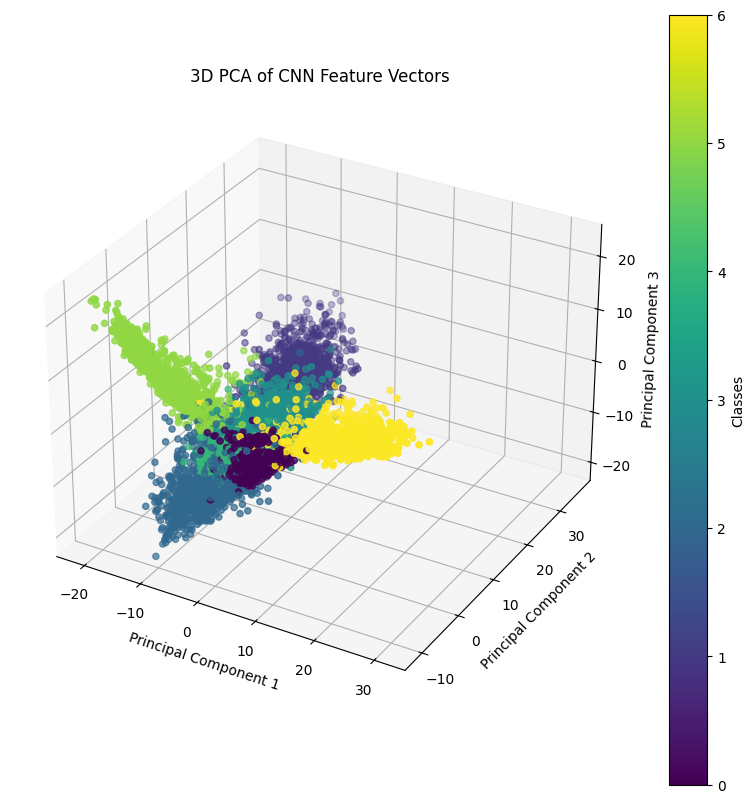

In [29]:
true_labels = np.argmax(y_test, axis=1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=true_labels, cmap='viridis')

colorbar = plt.colorbar(scatter)
colorbar.set_label('Classes')

ax.set_title('3D PCA of CNN Feature Vectors')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [30]:
def cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

Epoch 1/7


2024-05-29 18:20:05.876739: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 479ms/step - loss: 0.0950 - val_loss: 0.0817
Epoch 2/7
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step - loss: 0.0816 - val_loss: 0.0817
Epoch 3/7
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - loss: 0.0829 - val_loss: 0.0817
Epoch 4/7
83/83 ━━━━━━━━━━━━━━━━━━━━ 39s 464ms/step - loss: 0.0826 - val_loss: 0.0817
Epoch 5/7
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 463ms/step - loss: 0.0826 - val_loss: 0.0817
Epoch 6/7
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - loss: 0.0824 - val_loss: 0.0817
Epoch 7/7
83/83 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - loss: 0.0819 - val_loss: 0.0817


Text(0, 0.5, 'loss')

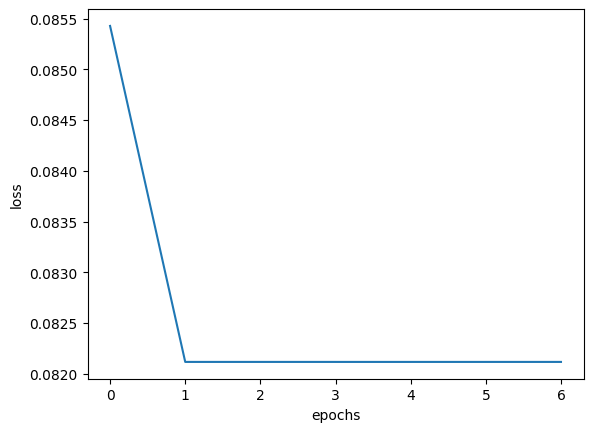

In [31]:
input_size = (56, 96, 3)
cnn_ae= cnn_autoencoder(input_size)
cnn_ae_history = cnn_ae.fit(X_train, X_train, epochs=7, batch_size=256, validation_data=(X_test, X_test))
plt.plot(cnn_ae_history.history['loss']);
plt.xlabel('epochs')
plt.ylabel('loss')

In [32]:
def predict(model, x: np.array, labels: list, file_name: str = None) -> np.array:
    """
    Plots the figures for which we want to predict the class alongside
    the predicted probabilities of each class.

    :param model: Keras model
    :param numpy.array x: a few test points to predict
    :param list labels: the list of labels associated with classes 0, ..., 9
    :param str file_name: (optional) filename to save the plot
    :return: the class prediction
    """
    lab = ['CSGO', 'Fortnite', 'Forza Horizon', 'Genshin impact', 'Minecraft', 'Terraria',
 'Valorant']


    y = model.predict(x)
    f, axes = plt.subplots(x.shape[0], 2, figsize=(33, 24))
    for i in range(x.shape[0]):
        axes[i, 0].imshow(x[i])
        axes[i, 1].barh(lab, y[i])
        
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()
    return y

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


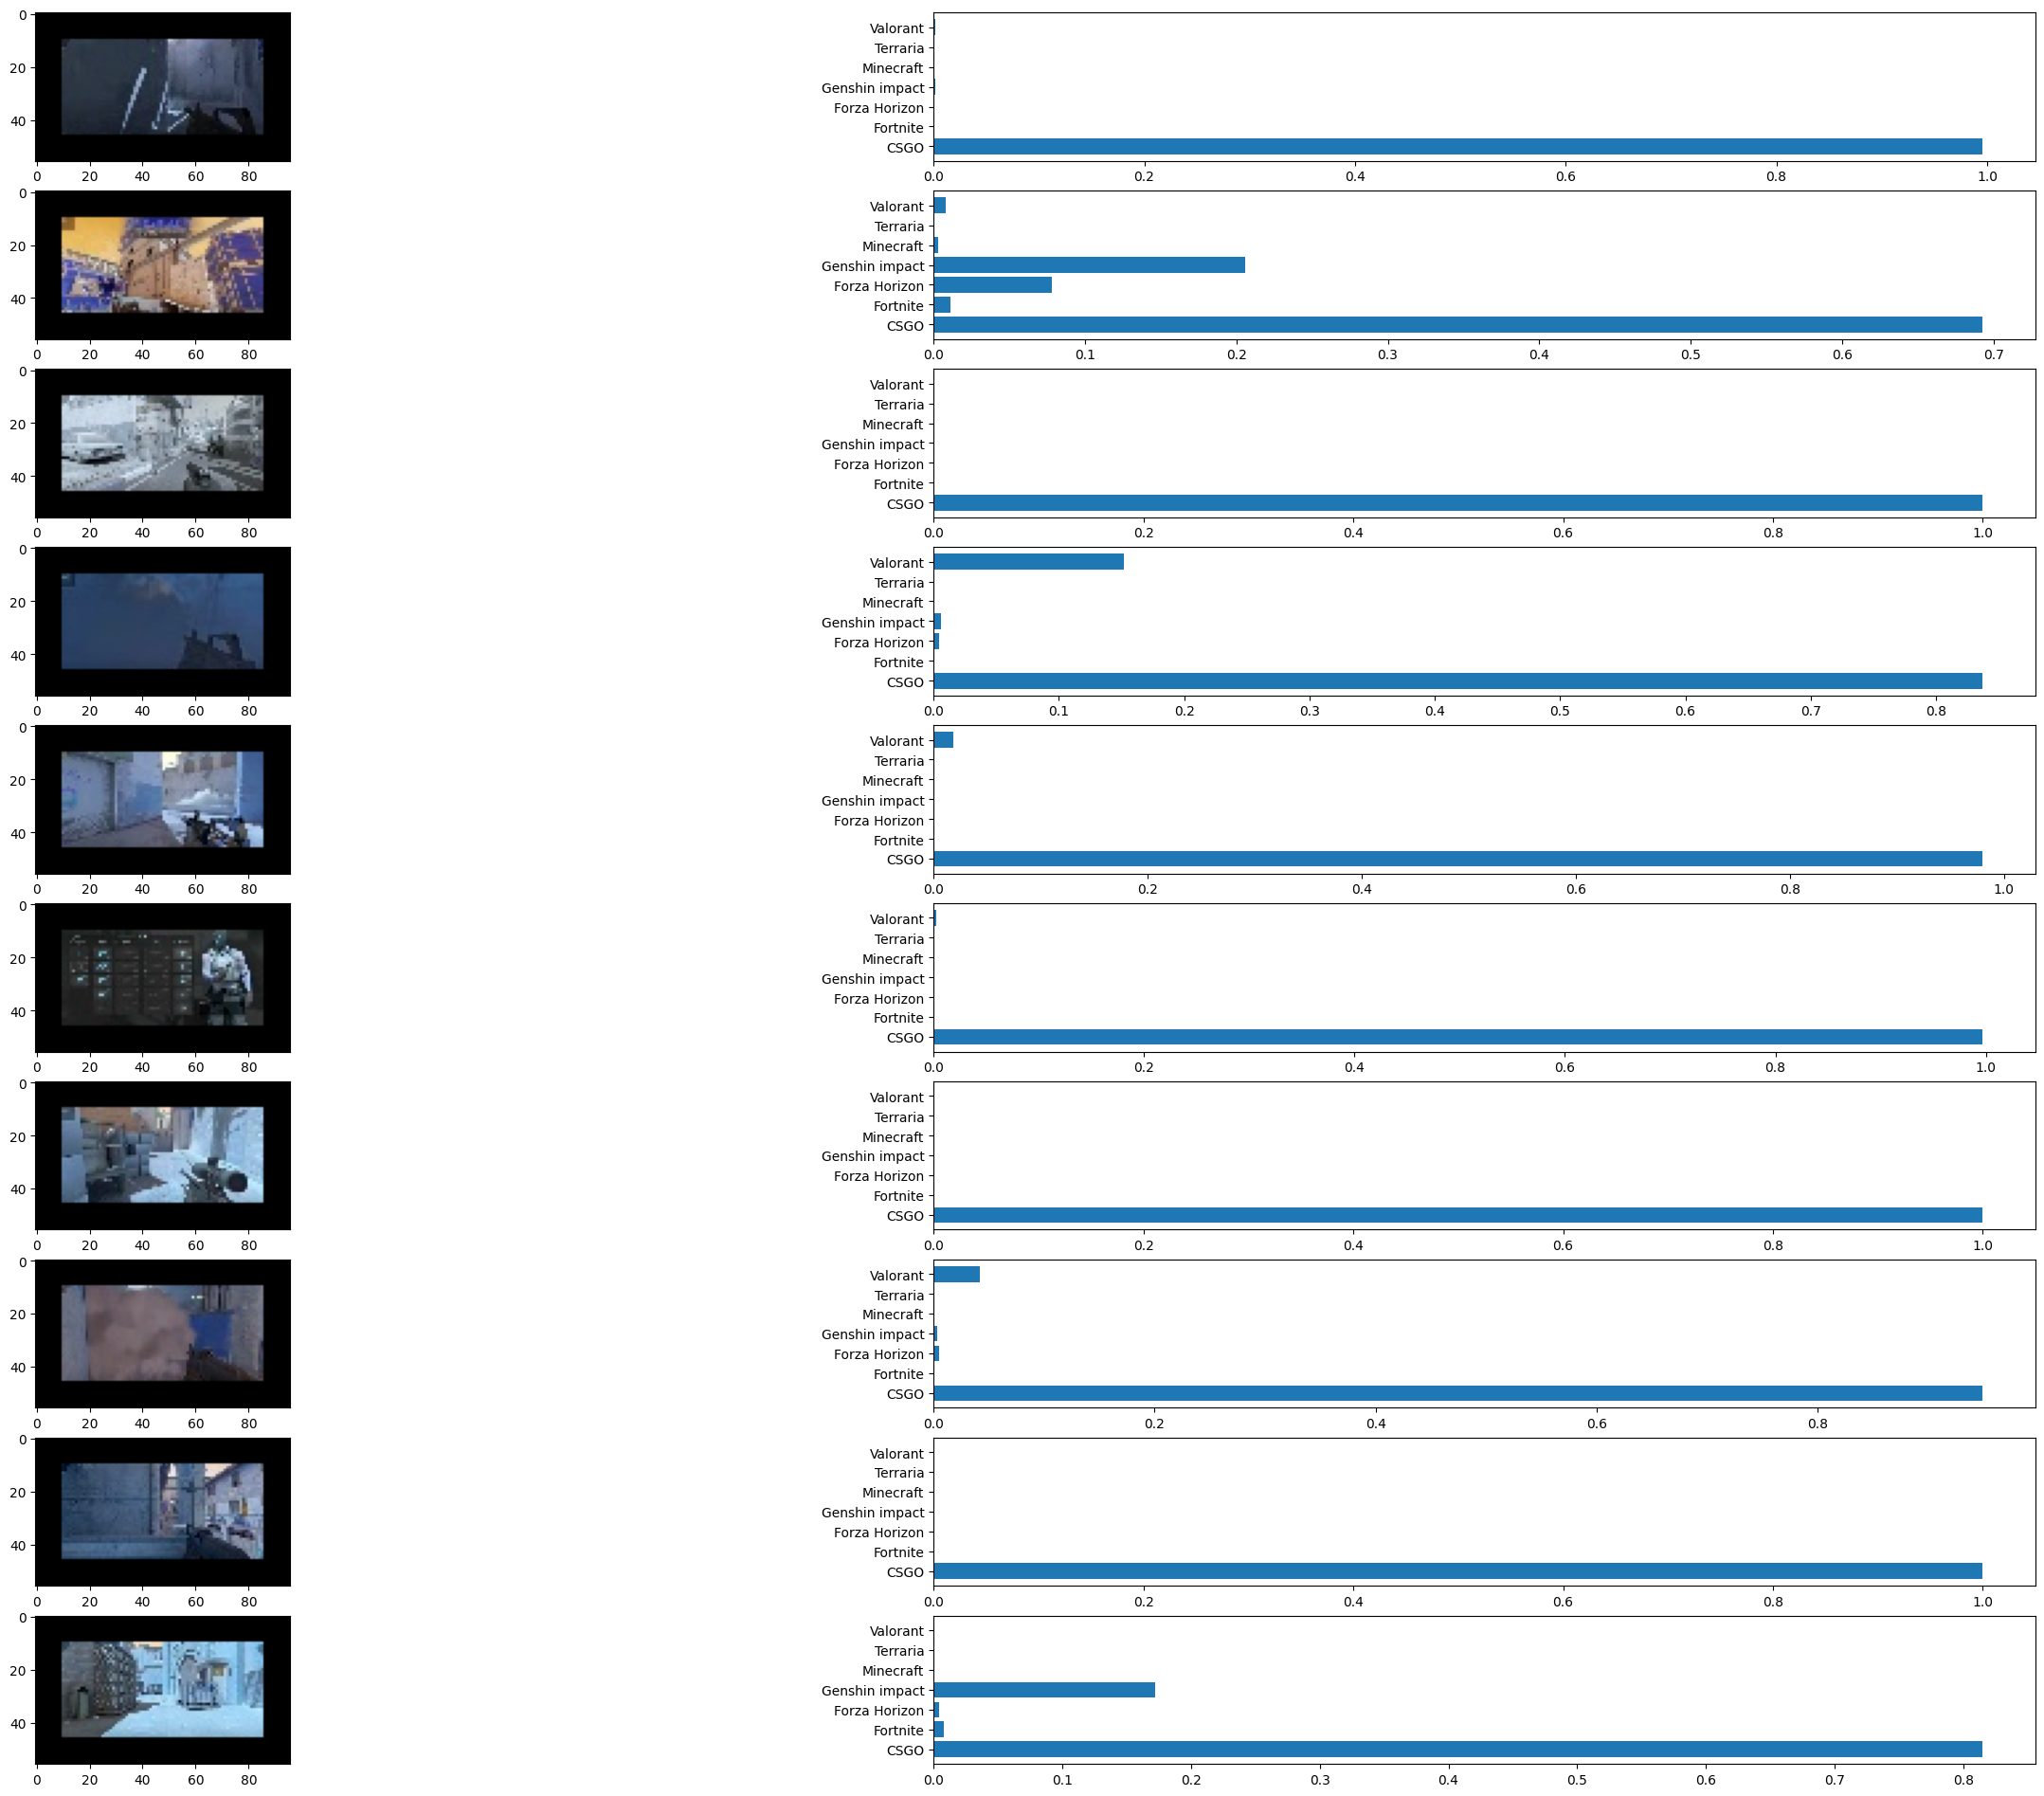

array([[9.9587125e-01, 3.8017836e-04, 1.3039754e-04, 1.7127509e-03,
        7.8457124e-05, 3.5494351e-05, 1.7914223e-03],
       [6.9295508e-01, 1.1025602e-02, 7.8157432e-02, 2.0602685e-01,
        3.1161229e-03, 7.9460745e-04, 7.9243761e-03],
       [9.9992454e-01, 2.7671331e-07, 2.7191612e-05, 4.5829765e-05,
        3.2004106e-08, 5.1632480e-08, 2.1617284e-06],
       [8.3732367e-01, 1.2109090e-05, 4.2536110e-03, 6.1379788e-03,
        4.6114612e-04, 3.1252232e-05, 1.5178025e-01],
       [9.8017645e-01, 4.8401108e-07, 1.0858894e-03, 3.5641214e-04,
        1.2991470e-06, 4.9226372e-07, 1.8378902e-02],
       [9.9703950e-01, 1.0812216e-08, 8.0499602e-05, 7.7490164e-05,
        8.0962036e-06, 1.0901538e-06, 2.7933756e-03],
       [9.9995673e-01, 1.6611237e-08, 4.6067737e-07, 1.9287133e-06,
        4.6093945e-10, 3.7475276e-09, 4.0898311e-05],
       [9.4951004e-01, 9.8336914e-06, 5.2320329e-03, 3.1662360e-03,
        3.3702992e-05, 2.0947273e-05, 4.2027079e-02],
       [9.9999166e-01, 3

In [33]:
predict(model, X_test[:10], y_test[:10])

In [34]:

def confusion_matrix(model, x_test: np.array, y_test: np.array, labels: list) -> pd.DataFrame:
    """
    Predict on x_test using model
    Use sklearn.metrics.confusion_matrix to get the matrix
    Prettify the result

    :param model: keras model
    :param numpy.array x: a few test points to predict
    :param numpy.array x: true values associated with x_test
    :param list labels: list of names of labels
    """
    lab = ['CSGO', 'Fortnite', 'Forza Horizon', 'Genshin impact', 'Minecraft', 'Terraria',
 'Valorant']

    
    pred = model.predict(x_test)
    df = pd.DataFrame(metrics.confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
    # making the table look fancy
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    df = df.rename({i: lab[i] for i in range(len(lab))}, axis='columns')
    df = df.rename({i: lab[i] for i in range(len(lab))})
    return df

In [35]:
conf_matrix = confusion_matrix(model_0, X_test, y_test, label_names)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [36]:
conf_matrix

,CSGO,Fortnite,Forza Horizon,Genshin impact,Minecraft,Terraria,Valorant
CSGO,527,0,255,16,5,9,188
Fortnite,4,652,165,39,10,4,126
Forza Horizon,9,0,911,5,3,27,45
Genshin impact,54,6,266,455,44,28,147
Minecraft,13,2,158,55,614,4,154
Terraria,3,25,31,46,22,860,13
Valorant,3,3,38,24,1,0,931


In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914,377 (3.49 MB)

 Trainable params: 913,927 (3.49 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)